In [1]:
# Salma Chaaban - 301216551
# COMP257 - Assignment 6

# Implementation of Deep Q-Learning 

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input
import numpy as np
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.animation
import matplotlib.pyplot as plt
import gym
from collections import deque

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [5]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

In [6]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

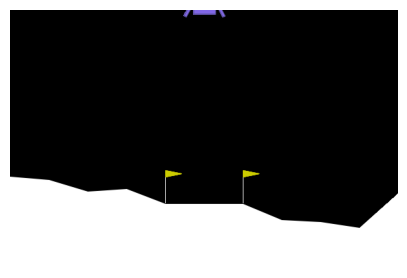

In [7]:
# creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [8]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

In [9]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = env.observation_space.shape[0]
n_outputs = env.action_space.n

# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
#     tf.keras.layers.Dense(32, activation="elu"),
#     tf.keras.layers.Dense(n_outputs)
# ])

model = Sequential([
        Dense(128, input_dim=input_shape, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(n_outputs, activation='linear')  # Linear for Q-values
    ])


c:\Users\salma\anaconda3\envs\py310_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Using Epsilon Greedy Policy

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [10]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

We will also need a replay buffer. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [11]:

replay_buffer = deque(maxlen=2000)

In [12]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]


And let's create a function to sample experiences from the replay buffer. It will return 6 NumPy arrays: `[obs, actions, rewards, next_obs, dones, truncateds]`.

In [13]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]


Now we can create a function that will use the DQN to play one step, and record its experience in the replay buffer:

In [14]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info


Lastly, let's create a function that will sample some experiences from the replay buffer and perform a training step:

In [15]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0


In [16]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = MeanSquaredError()

# def training_step(batch_size):
#     experiences = sample_experiences(batch_size)
#     states, actions, rewards, next_states, dones, truncateds = experiences
#     next_Q_values = model.predict(next_states, verbose=0)
#     max_next_Q_values = next_Q_values.max(axis=1)
#     runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
#     target_Q_values = rewards + runs * discount_factor * max_next_Q_values
#     target_Q_values = target_Q_values.reshape(-1, 1)
#     mask = tf.one_hot(actions, n_outputs)
#     with tf.GradientTape() as tape:
#         all_Q_values = model(states)
#         Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
#         loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

#     grads = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def training_step(batch_size):
    # Sample experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    
    # Predict next Q-values
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    # Compute the target Q-values
    runs = 1.0 - (dones | truncateds).astype(np.float32)  # Ensure float for scaling
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values

    # Use one-hot encoding for the actions
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        # Get Q-values for the current states
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

        # Compute the loss
        loss = tf.reduce_mean(loss_fn(target_Q_values[:, np.newaxis], Q_values))
    
    # Apply gradients
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))



And now, let's train the model!

In [17]:
for episode in range(1000):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights


Episode: 1000, Steps: 200, eps: 0.010

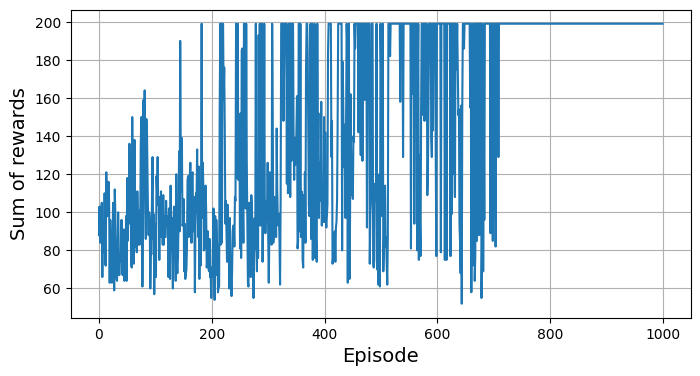

In [18]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
#save_fig("dqn_rewards_plot")
plt.show()


In [19]:
# shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)
